In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt

In [4]:
def convertir_fechas(df):
    # Asegura que Timestamp_Pronostico sea datetime completo
    df['Timestamp_Pronostico'] = pd.to_datetime(df['Timestamp_Pronostico'])

    # Asegura que Fecha sea solo fecha (sin hora)
    df['Fecha'] = pd.to_datetime(df['Fecha']).dt.date

    return df

In [5]:
pronostico_met_df_2022 = pd.read_csv('pronostico_consolidado_2022_Curico.csv')
pronostico_met_df_2023 = pd.read_csv('pronostico_consolidado_2023_Curico.csv')
pronostico_met_df_2024 = pd.read_csv('pronostico_consolidado_2024_Curico.csv')

pronostico_co_df_2022 = pd.read_csv('pronostico_consolidado_completo_CO_2022.csv')
pronostico_co_df_2023 = pd.read_csv('pronostico_consolidado_completo_CO_2023.csv')
pronostico_co_df_2024 = pd.read_csv('pronostico_consolidado_completo_CO_2024.csv')

In [6]:
pronostico_mp25_baseline = pd.read_csv("df_pronostico_mp25.csv")

In [7]:
pronostico_met_df = pd.concat([pronostico_met_df_2022, pronostico_met_df_2023, pronostico_met_df_2024])
pronostico_co_df = pd.concat([pronostico_co_df_2022, pronostico_co_df_2023, pronostico_co_df_2024])

In [8]:
pronostico_met_df = convertir_fechas(pronostico_met_df)
pronostico_co_df = convertir_fechas(pronostico_co_df)

In [9]:
df_pronosticos = pd.merge(
    pronostico_met_df,
    pronostico_co_df,
    on=['Fecha', 'Timestamp_Pronostico', 'Region'],  # también es clave la Región
    how='inner'  # puedes cambiar a 'left', 'outer' o 'right' según el análisis
)
print(len(df_pronosticos))

72263


In [10]:
def limpiar_pronosticos(df, need_cut=True, first_val=-1):
  df = df.sort_values(by="Timestamp_Pronostico")
  if need_cut:
    df = df[4:-3]
  df['horizonte'] = [i for i in range(first_val, 4) for _ in range(24)]
  return df

In [11]:
df_pronosticos = df_pronosticos.groupby('Fecha').apply(limpiar_pronosticos).reset_index(drop=True)

/var/folders/_3/lz7prpr562j68q4k459330180000gp/T/ipykernel_57972/1442696180.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pronosticos = df_pronosticos.groupby('Fecha').apply(limpiar_pronosticos).reset_index(drop=True)


In [12]:
observados_df = pd.read_csv('datos_observados_curico.csv', index_col=0)[['Timestamp', 'TEMP', 'WDIR', 'RHUM', 'WSPD', 'MP25_validado', 'MP25_preliminar', 'MP25_no_validado']]

In [13]:
def imputar_mp25(df):
    df = df.copy()

    df['MP25_validado'] = df['MP25_validado'].combine_first(df['MP25_no_validado'])
    df['MP25_validado'] = df['MP25_validado'].combine_first(df['MP25_preliminar'])

    return df

observados_df = imputar_mp25(observados_df)

In [14]:
# Imputación por interpolación lineal solo entre valores válidos
def imputar_nan_lineal(df, columnas):
    df_resultado = df.copy()
    for col in columnas:
        df_resultado[col] = df_resultado[col].interpolate(method='linear', limit_direction='both')
    return df_resultado

# Columnas a imputar (puedes ajustarlas si cambia tu dataset)
columnas_a_imputar = ['TEMP', 'WDIR', 'RHUM', 'WSPD', 'MP25_validado']

# Aplicar función
observados_df = imputar_nan_lineal(observados_df, columnas_a_imputar)

In [15]:
# convertir a utc-4
observados_df['Timestamp'] = pd.to_datetime(observados_df['Timestamp'])

In [16]:
observados_df.head(3)

,Timestamp,TEMP,WDIR,RHUM,WSPD,MP25_validado,MP25_preliminar,MP25_no_validado
0,2022-01-01 01:00:00,15.1225,184.449,0.237583,1.86197,3.0,NaN,NaN
1,2022-01-01 02:00:00,14.0492,180.856,0.238750,1.48135,5.0,NaN,NaN
2,2022-01-01 03:00:00,13.1550,171.097,0.235000,1.09304,5.0,NaN,NaN


In [17]:
# Asegurarse de que esté ordenado cronológicamente
observados_df = observados_df.sort_values('Timestamp')

def mm(df, columna, decimals=0, ventana=24):
    def promedio_personalizado(x):
        no_nulos = x.dropna()
        if len(x) - len(no_nulos) < 7:
            return round(no_nulos.mean(), decimals)
        else:
            return np.nan  # << aquí el cambio importante

    resultado = df[columna].rolling(window=ventana, min_periods=1).apply(promedio_personalizado, raw=False)
    return resultado

# Aplicar función y crear columna MP25_mm
observados_df['MP25_mm'] = mm(observados_df, 'MP25_validado', decimals=2)


## Feature Engineering con variables compuestas

In [18]:
# Asegurar que 'Timestamp_Pronostico' sea datetime
df_pronosticos['Timestamp_Pronostico'] = pd.to_datetime(df_pronosticos['Timestamp_Pronostico'])

# Extraer componentes temporales
df_pronosticos['hour'] = df_pronosticos['Timestamp_Pronostico'].dt.hour
df_pronosticos['dayofweek'] = df_pronosticos['Timestamp_Pronostico'].dt.dayofweek
df_pronosticos['dayofyear'] = df_pronosticos['Timestamp_Pronostico'].dt.dayofyear

# Codificación cíclica
df_pronosticos['hour_sin'] = np.sin(2 * np.pi * df_pronosticos['hour'] / 24)
df_pronosticos['hour_cos'] = np.cos(2 * np.pi * df_pronosticos['hour'] / 24)

df_pronosticos['dayofweek_sin'] = np.sin(2 * np.pi * df_pronosticos['dayofweek'] / 7)
df_pronosticos['dayofweek_cos'] = np.cos(2 * np.pi * df_pronosticos['dayofweek'] / 7)

df_pronosticos['dayofyear_sin'] = np.sin(2 * np.pi * df_pronosticos['dayofyear'] / 365)
df_pronosticos['dayofyear_cos'] = np.cos(2 * np.pi * df_pronosticos['dayofyear'] / 365)

# Dirección del viento como ángulo cíclico
df_pronosticos['WDIR_sin'] = np.sin(np.deg2rad(df_pronosticos['WDIR']))
df_pronosticos['WDIR_cos'] = np.cos(np.deg2rad(df_pronosticos['WDIR']))


In [19]:
df_pronosticos['TEMP_WSPD'] = df_pronosticos['TEMP'] * df_pronosticos['WSPD']
df_pronosticos['CO_TEMP'] = df_pronosticos['CO(CENTRO)'] * df_pronosticos['TEMP']
df_pronosticos['CO_SO2'] = df_pronosticos['CO(CENTRO)'] / (df_pronosticos['SO2(CENTRO)'] + 1e-5)

feature_cols = [
    'TEMP', 'WSPD', 'WDIR_sin', 'WDIR_cos', 'CO(CENTRO)', 'SO2(CENTRO)',
    'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos',
    'TEMP_WSPD', 'CO_TEMP', 'CO_SO2'
]

In [20]:
resultados = []
for fecha, grupo in df_pronosticos.groupby('Fecha'):
    grupo = grupo.sort_values('Timestamp_Pronostico').reset_index(drop=True)
    for idx, row in grupo.iterrows():
        if row['horizonte'] >= 0:
            ts = row['Timestamp_Pronostico']
            ventana = grupo[idx-24+1:idx+1]
            if len(ventana) == 24:
                resultados.append({
                    'Fecha': fecha,
                    'Timestamp_Pronostico': ts,
                    'Features': ventana[feature_cols].values,
                    'horizonte': row['horizonte']
                })

df_final = pd.DataFrame(resultados)

In [21]:
# Calcular log del target
df_modelo = df_final.merge(observados_df[['Timestamp', 'MP25_mm']], how='left', left_on='Timestamp_Pronostico', right_on='Timestamp')
df_modelo['MP25_log'] = np.log1p(df_modelo['MP25_mm'])

# Dividir por años
df_train = df_modelo[df_modelo['Timestamp_Pronostico'].dt.year.isin([2022, 2023])]
df_test = df_modelo[df_modelo['Timestamp_Pronostico'].dt.year == 2024]

In [22]:
X_train = np.stack(df_train['Features'].values)
y_train = df_train['MP25_log'].values
X_test = np.stack(df_test['Features'].values)
y_test = df_test['MP25_log'].values

# 🔹 Filtrar valores nulos antes de escalar
valid_idx = ~np.isnan(y_train)
X_train = X_train[valid_idx]
y_train = y_train[valid_idx]
df_train = df_train[valid_idx]

In [23]:
# 🔹 Escalamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

# 🔹 Pesos por picos
sample_weight = np.ones_like(y_train)
sample_weight[y_train > np.log1p(80)] = 20


In [24]:
# --- DEFINICIÓN DEL MODELO LSTM ---
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_lstm_model((X_train_scaled.shape[1], X_train_scaled.shape[2]))

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_lstm_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
]


/Users/jimmyibanez/Projects/tesis_efg3_jimmy/tesis_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# --- ENTRENAMIENTO ---
history = model.fit(
    X_train_scaled, y_train,
    sample_weight=sample_weight,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
905/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3834 - mae: 0.8831
Epoch 1: val_loss improved from inf to 0.45632, saving model to best_lstm_model.h5


910/910 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 3.3688 - mae: 0.8810 - val_loss: 0.4563 - val_mae: 0.3358 - learning_rate: 0.0010
Epoch 2/100
904/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4103 - mae: 0.3919
Epoch 2: val_loss did not improve from 0.45632
910/910 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.4100 - mae: 0.3918 - val_loss: 0.4929 - val_mae: 0.3623 - learning_rate: 0.0010
Epoch 3/100
909/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3506 - mae: 0.3575
Epoch 3: val_loss did not improve from 0.45632
910/910 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.3506 - mae: 0.3575 - val_loss: 0.5223 - val_mae: 0.3673 - learning_rate: 0.0010
Epoch 4/100
905/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3075 - mae: 0.3279
Epoch 4: val_loss improved from 0.45632 to 0.41417, saving model to best_lstm_model.h5


910/910 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.3075 - mae: 0.3279 - val_loss: 0.4142 - val_mae: 0.4124 - learning_rate: 0.0010
Epoch 5/100
909/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3010 - mae: 0.3148
Epoch 5: val_loss did not improve from 0.41417
910/910 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.3009 - mae: 0.3148 - val_loss: 0.5103 - val_mae: 0.3736 - learning_rate: 0.0010
Epoch 6/100
903/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2404 - mae: 0.2844
Epoch 6: val_loss did not improve from 0.41417
910/910 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.2404 - mae: 0.2844 - val_loss: 0.4496 - val_mae: 0.3584 - learning_rate: 0.0010
Epoch 7/100
910/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2290 - mae: 0.2736
Epoch 7: val_loss did not improve from 0.41417
910/910 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.2290 - mae: 0.2736 - val_loss: 0.4831 - val_mae: 0.3685 - learning_rate: 0.0010
Epoch 8/100
905/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2193 - mae: 0.2621
Epoch 8

In [26]:
# --- PREDICCIÓN Y EVALUACIÓN ---
y_pred = model.predict(X_test_scaled)

df_test = df_test.copy()
df_test['pred'] = np.expm1(y_pred).flatten()
df_test['MP25_mm'] = np.expm1(df_test['MP25_log'])

# Separar por horizonte
df_test0 = df_test[df_test['horizonte'] == 0]
df_test1 = df_test[df_test['horizonte'] == 1]
df_test2 = df_test[df_test['horizonte'] == 2]
df_test3 = df_test[df_test['horizonte'] == 3]

570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


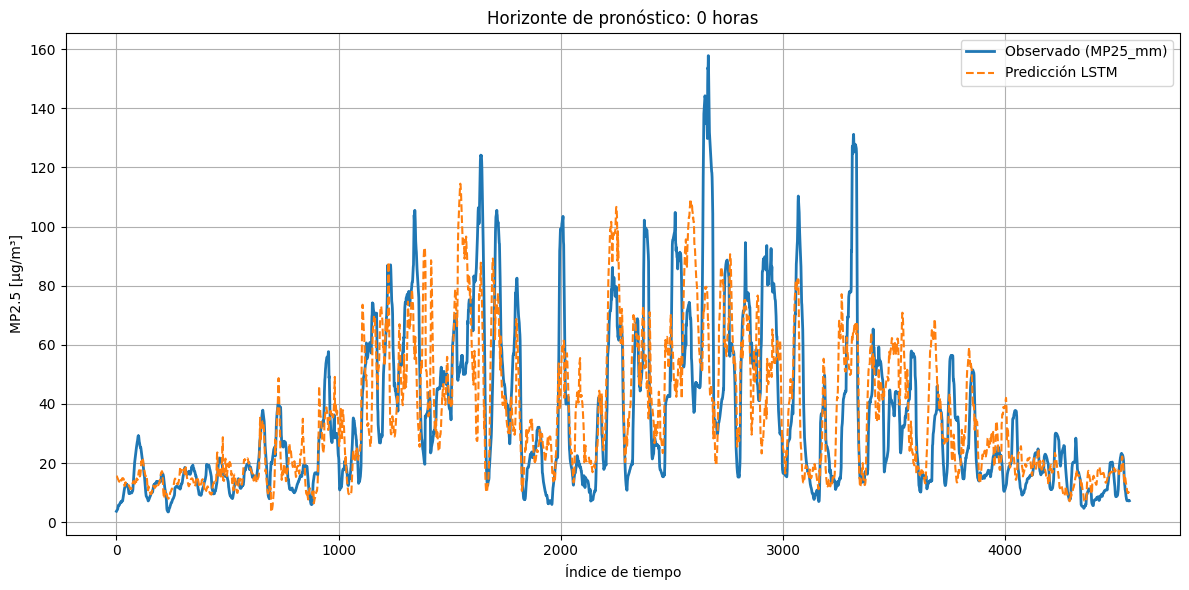

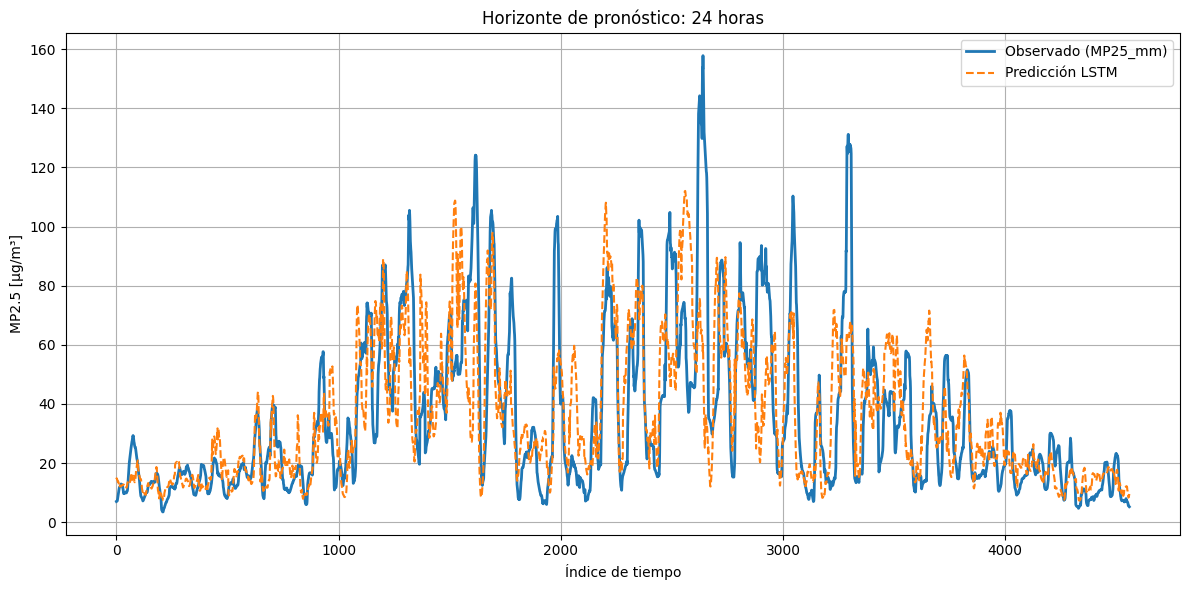

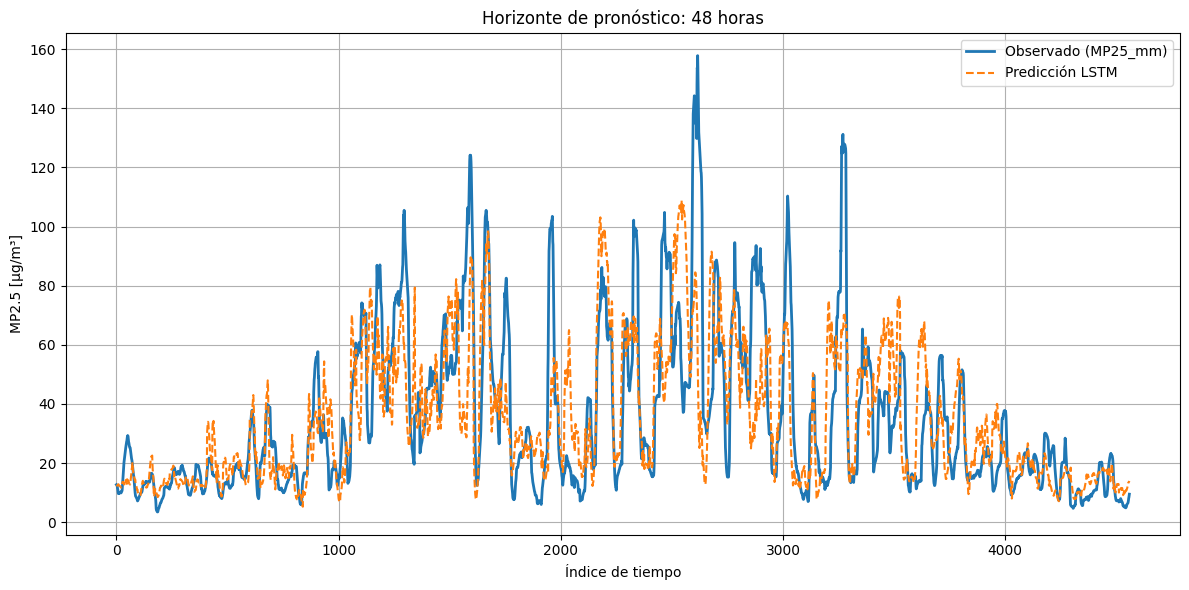

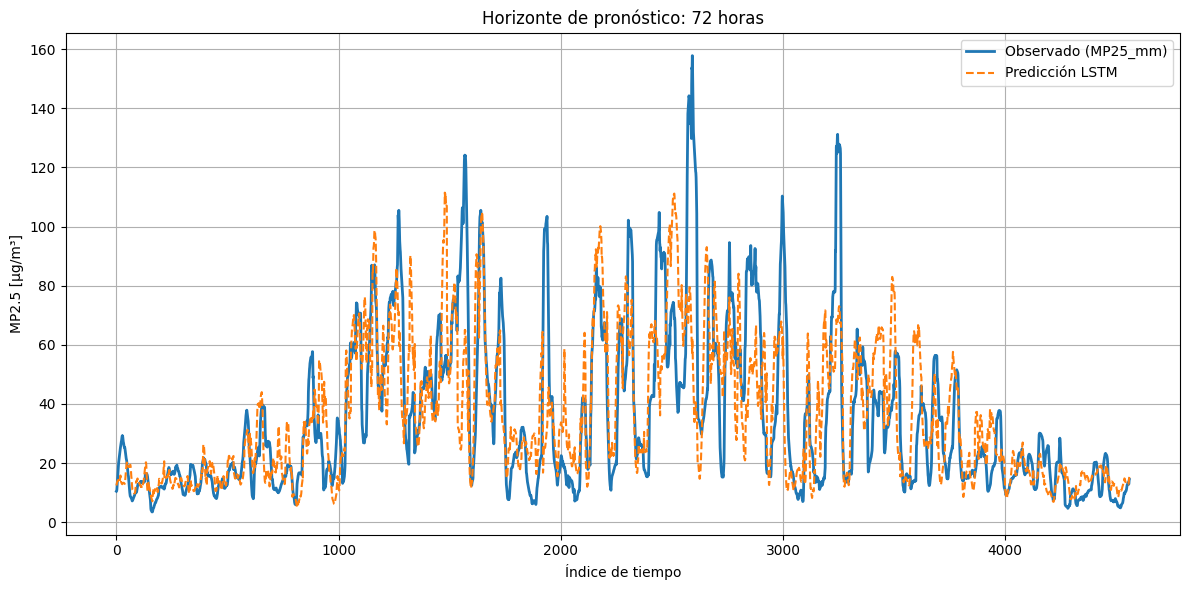

In [27]:
import matplotlib.pyplot as plt

for i, _df in enumerate([df_test0, df_test1, df_test2, df_test3]):
    plt.figure(figsize=(12, 6))
    plt.plot(_df['MP25_mm'].values, label='Observado (MP25_mm)', linewidth=2)
    plt.plot(_df['pred'].values, label='Predicción LSTM', linestyle='--')
    plt.xlabel('Índice de tiempo')
    plt.ylabel('MP2.5 [µg/m³]')
    plt.title(f'Horizonte de pronóstico: {i * 24} horas')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [28]:
def get_metricas_sin_nan(y_true_log, y_pred_lin, nombre=""):
    mask = ~(np.isnan(y_true_log) | np.isnan(y_pred_lin))
    y_true_log = y_true_log[mask]
    y_pred_lin = y_pred_lin[mask]

    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(np.log1p(y_pred_lin))

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    r, _ = pearsonr(y_true, y_pred)
    fb = 2 * (y_pred.mean() - y_true.mean()) / (y_pred.mean() + y_true.mean()) if (y_pred.mean() + y_true.mean()) != 0 else np.nan

    print(f"--- {nombre} ---")
    print(f"RMSE     : {rmse:.2f}")
    print(f"MAE      : {mae:.2f}")
    print(f"R²       : {r2:.3f}")
    print(f"FB       : {fb:.3f}")
    print(f"Pearson r: {r:.3f}")
    print()

    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'fb': fb,
        'r': r
    }


In [29]:
metricas_h0 = get_metricas_sin_nan(df_test0['MP25_log'].values, df_test0['pred'].values, nombre="Horizonte 0")
metricas_h1 = get_metricas_sin_nan(df_test1['MP25_log'].values, df_test1['pred'].values, nombre="Horizonte 1")
metricas_h2 = get_metricas_sin_nan(df_test2['MP25_log'].values, df_test2['pred'].values, nombre="Horizonte 2")
metricas_h3 = get_metricas_sin_nan(df_test3['MP25_log'].values, df_test3['pred'].values, nombre="Horizonte 3")


--- Horizonte 0 ---
RMSE     : 20.64
MAE      : 14.15
R²       : 0.427
FB       : 0.005
Pearson r: 0.673

--- Horizonte 1 ---
RMSE     : 20.88
MAE      : 14.18
R²       : 0.413
FB       : -0.003
Pearson r: 0.665

--- Horizonte 2 ---
RMSE     : 20.54
MAE      : 14.01
R²       : 0.433
FB       : -0.018
Pearson r: 0.674

--- Horizonte 3 ---
RMSE     : 20.46
MAE      : 13.89
R²       : 0.437
FB       : 0.005
Pearson r: 0.681

